In [46]:
#Import Packages
import scipy as sp
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import speed_of_light
import pickle
import pandas as pd
import glob
import os
from pprint import pprint
from datetime import datetime
from progressbar import ProgressBar, Bar, Percentage
from ipywidgets import IntProgress
from IPython.display import display
from scipy import signal
from scipy.signal import hann

In [47]:
#Global Constants [edited]
maxRange = 25
chirpDur = 125
c0 = speed_of_light
switchPer = 625e-6
modF = 1 / (2 * switchPer)
modDuty = 50
fs = 1.0e6
vel = 2.0
gran = 0.2
cutoff = 15

In [48]:
#Template Definitions [edited]
def hanning(M, *varargin):
    Win = hann(M)
    if len(varargin) > 0:
        N = varargin[0]
        Win = np.broadcast_to(Win, (N, M)).T
    return Win

In [49]:
#Insert Datafile Directory [edited*]
dir = '/Users/Anant/MMetroDEnv/PythonCodev2/Data/'
names = [x for x in glob.glob(dir + '*ryu_motion3-24GHz.pickle')]
names.sort()
pprint(names)

['/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-140854-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141102-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141154-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141246-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141341-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141537-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141733-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141830-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141931-ryu_motion3-24GHz.pickle']


In [50]:
#Get Range Profile and Doppler Profile [same]
def get_RP_RD(data_snapshot, cfg, nFFT, nFFT_vel):
    '''========================= setting config information ============================='''
    frmMeasSiz = cfg['FrmMeasSiz']
    N = cfg['N']
    TRampUp = cfg['TRampUp']   
    kf = (cfg['fStop'] - cfg['fStrt']) / cfg['TRampUp']
    vRange = np.arange(nFFT) / nFFT * fs * c0 / (2*kf)
    fc = (cfg['fStop'] + cfg['fStrt']) / 2
    
    RMin = 5
    RMax = min(maxRange, (N / TRampUp) * c0 / (4 * 250e6 / TRampUp))
    RMinIdx = np.argmin(np.abs(vRange - RMin))
    RMaxIdx = np.argmin(np.abs(vRange - RMax))
    vRangeExt = vRange[RMinIdx:RMaxIdx]
    
    # reshape the data
    data = np.reshape(data_snapshot, (N, frmMeasSiz), order='F')
    data = data - data[:,0][:,None]
    
    '''================================ getting RP ====================================='''
    # hanning window used for getting RP
    Win2D = hanning(N, int(frmMeasSiz))
    ScaWin = sum(Win2D[:, 0])
    
    RP = 2 * np.fft.fft(np.multiply(data, Win2D), n=nFFT, axis=0) / ScaWin * 0.498 / 65536
    
    '''================================= getting RD ====================================='''
    # hanning window used for getting RD
    WinVel2D = hanning(int(frmMeasSiz), len(vRangeExt))
    ScaWinVel = sum(WinVel2D[:, 0])
    WinVel2D = WinVel2D.transpose()
    
    # getting RD
    RPExt = RP[RMinIdx:RMaxIdx, :]
    RD = np.fft.fft(np.multiply(RPExt, WinVel2D), n=nFFT_vel, axis=1) / ScaWinVel
    
    return RPExt, RD, vRangeExt

In [51]:
#Plot Doppler 
def plot_doppler(file_name, frame_idx, save_fig = False, save_RD_norm = False, save_dir = 'Data/'):
    # load data from file name
    file = open(file_name, 'rb')
    data_raw = pickle.load(file)
    file.close()
    
    # get singe channel raw data and its config
    data_single_chn = data_raw['Data'][:,:,0] # select one channel (antena)
    data_snapshot = data_single_chn[:,frame_idx]
    cfg = data_raw['Cfg']
 
    # get RP and RD
    nFFT = 2**10
    nFFT_vel = 2**8
    RPExt, RD, vRangeExt = get_RP_RD(data_snapshot, cfg, nFFT, nFFT_vel)
    
    # normalize RD for plotting
    RD = RD[:,cutoff:-cutoff]
    RD_diff = np.abs(RD) - np.min(np.abs(RD))
    RD_norm = RD_diff / np.max(np.abs(RD))
    
    # Get information for plotting
    fc = (cfg['fStop'] + cfg['fStrt']) / 2
    vFreqVel = np.arange(-nFFT_vel//2, nFFT_vel//2)/nFFT_vel*(1/cfg['Perd'])
    vVel = (vFreqVel*c0/(2*fc))[10:-10]
    
    vRangeExtVisIdx = np.arange(0, vRangeExt.shape[0], 20)
    vRangeExtVis = list(map(lambda x: "%.2f" % x, vRangeExt[vRangeExtVisIdx]))
    vVelVisIdx = np.arange(0, vVel.shape[0], 50)
    vVelVis = list(map(lambda x: "%.2f" % x, vVel[vVelVisIdx]))
    chirpVisIdx = np.arange(0, cfg["FrmMeasSiz"], 50)
    
    # plotting RP and RD
    fig, axes = plt.subplots(1, 2)
    fig.subplots_adjust(wspace=0.4)
    axes[0].imshow(np.abs(RPExt), aspect='auto')
    axes[0].set_title("Range Profile")
    axes[0].set_xticks(chirpVisIdx)
    axes[0].set_xlabel("Chirps")
    axes[0].set_yticks(vRangeExtVisIdx, labels=vRangeExtVis)
    axes[0].set_ylabel("Range (m)")

    axes[1].imshow(np.abs(RD), aspect='auto')
    axes[1].set_title("Doppler Profile")
    axes[1].set_xticks(vVelVisIdx, labels=vVelVis)
    axes[1].set_xlabel("Vel Bins")
    axes[1].set_yticks(vRangeExtVisIdx, labels=vRangeExtVis)
    axes[1].set_ylabel("Range (m)")
    
    # save figure/data setting
    if save_fig:
        path = save_dir + file_name[28:-7] + '/image'
        if not os.path.exists(path):
            os.makedirs(path)
        plt.savefig(path + '/frame_'+str(frame_idx)+'.png')
    if save_RD_norm:
        path = save_dir + file_name[28:-7] + '/RD_norm'
        if not os.path.exists(path):
            os.makedirs(path)
        np.save(path+'/frame_' + str(frame_idx) + '.npy', RD_norm)
        
    plt.show()

In [52]:
#Sync Template [same]
def sincTemplate(cfg, modF, modDuty, NFFTVel, vel):
    fc = (cfg['fStop'] + cfg['fStrt']) / 2
    c0 = 2.998e8
    t = np.linspace(0, cfg['Perd']*200, 200)
    doppShift = np.fft.fft(np.cos(2*np.pi*(2*vel*fc/c0*t)), n=NFFTVel, axis=0)
    undopp_square = np.fft.fft(sp.signal.square(2*np.pi*modF*t, modDuty/100), n=NFFTVel, axis=0)
    if vel > 0:
        doppShift[int(NFFTVel/2):] = 0
        sq_wav = np.convolve(doppShift, undopp_square)
        to_return = np.abs(sq_wav[:NFFTVel])
    elif vel<0:
        doppShift[int(NFFTVel/2):] = 0
        doppShift = np.flip(doppShift)
        sq_wav = np.convolve(doppShift, undopp_square)
        to_return = np.abs(sq_wav[NFFTVel-1:])
    else:
        to_return = np.abs(undopp_square)
    to_return = to_return / np.max(to_return)
    to_return[to_return<0.1] = 0
    return to_return

In [53]:
#Create Template [same]
def create_template(vel_list, cfg, NFFTVel):
    templateAll = np.zeros((len(vel_list), NFFTVel-cutoff*2))
    for vIdx in range(len(vel_list)):
        template = sincTemplate(cfg, modF, modDuty, NFFTVel, vel_list[vIdx])
        templateAll[vIdx] = template[cutoff:-cutoff]
    return templateAll

In [54]:
#Get Position [same]
def get_position(RD_norm, templateAll, vRangeExt):
    max_max_corr = 0
    max_idx = 0
    for i in range(len(templateAll)):
        template = templateAll[i]
        corr = np.abs(RD_norm) * np.repeat(np.abs(template[:, np.newaxis]), RD_norm.shape[0], axis = 1).T
        corr_sum = np.sum(np.abs(corr), axis=1)
        max_corr = np.max(corr_sum)
        if max_corr > max_max_corr:
            max_max_corr = max_corr
            max_idx = np.argmax(corr_sum)
                                
    range_idx = max_idx
    to_return = vRangeExt[range_idx]
    return to_return

In [55]:
#Get Timestamps
def get_timestamps(data_raw):
    date_time_obj = []
    first_timestamp = True
    for i in range(len(data_raw['dtime'])):
        date = data_raw['dtime'][i]
        while(len(date) < 23):
            pre = date[:20]
            post = date[20:]
            date = pre+'0'+post
            
        if first_timestamp:
            time_init = datetime.strptime(date, '%Y-%m-%d %H:%M:%S:%f')
            date_time_obj.append(0)
            first_timestamp = False
        else:
            delta = datetime.strptime(date, '%Y-%m-%d %H:%M:%S:%f') - time_init
            date_time_obj.append(delta.total_seconds()) 
    return date_time_obj

In [56]:
def process_plot(names, save=True, save_dir = 'Data/'):
    for names_i in range(len(names)):
        file = open(names[names_i], 'rb')
        data_raw = pickle.load(file)
        file.close()
        data_single_chn = data_raw['Data'][:,:,0]
        cfg = data_raw['Cfg']
        n_frame = data_single_chn.shape[1]
        position = np.zeros(n_frame)
        nFFT = 2**10
        nFFT_vel = 2**8
        
        pprint("start processing " + names[names_i])

        f = IntProgress(min=0, max=n_frame) # instantiate the bar
        display(f)
        for i in range(n_frame):
            data_snapshot = data_single_chn[:,i]
            RPExt, RD, vRangeExt = get_RP_RD(data_snapshot, cfg, nFFT, nFFT_vel)
            
            RD = RD[:,cutoff:-cutoff]
            RD_diff = np.abs(RD) - np.min(np.abs(RD))
            RD_norm = RD_diff / np.max(np.abs(RD))
            
            velArr = np.arange(-vel,vel,gran)
            templateAll = create_template(velArr, cfg, nFFT_vel)
            
            position[i] = get_position(RD_norm, templateAll, vRangeExt)
            f.value += 1
            
            
        timestamps = get_timestamps(data_raw)
                
        plt.plot(timestamps, position)
        plt.xlabel('time (ms)')
        plt.ylabel('range (m)')
        
        
        if save:
            to_save = [timestamps, position]
            path = save_dir + names[names_i][28:-7]
            if not os.path.exists(path):
                os.makedirs(path)
            np.save(path+ '/processed_range_time.npy', to_save)
            plt.savefig(path + '/range_time_plot.png')
            
        plt.show()

In [57]:
#Plot RP and DP

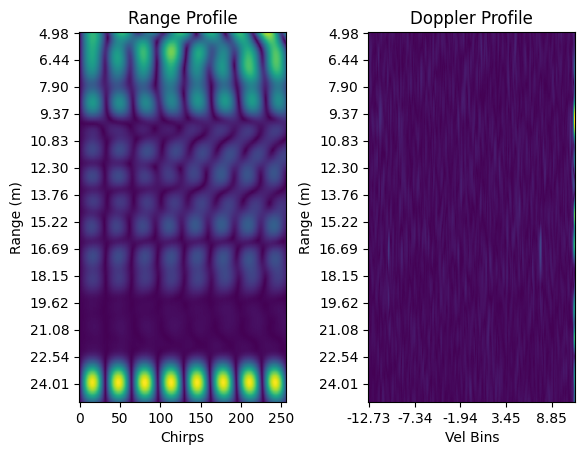

In [58]:
plot_doppler(names[6], 100, save_fig = True, save_RD_norm = True)

In [59]:
names

['/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-140854-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141102-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141154-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141246-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141341-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141537-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141733-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141830-ryu_motion3-24GHz.pickle',
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141931-ryu_motion3-24GHz.pickle']

('start processing '
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-140854-ryu_motion3-24GHz.pickle')


IntProgress(value=0, max=407)

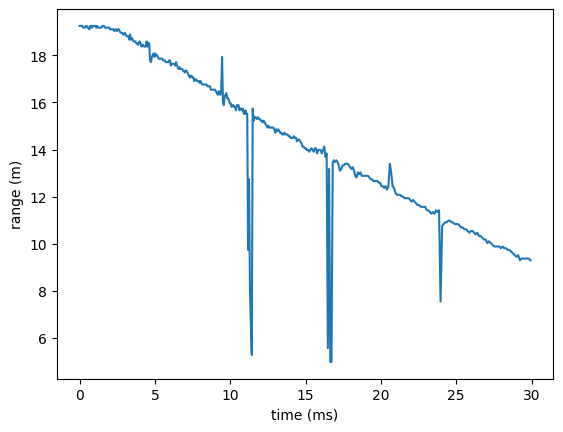

('start processing '
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141102-ryu_motion3-24GHz.pickle')


IntProgress(value=0, max=409)

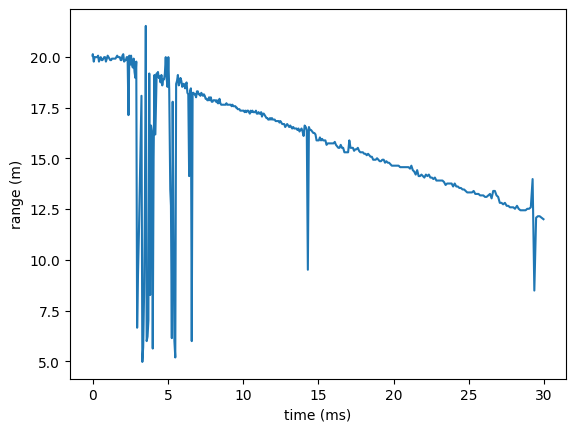

('start processing '
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141154-ryu_motion3-24GHz.pickle')


IntProgress(value=0, max=404)

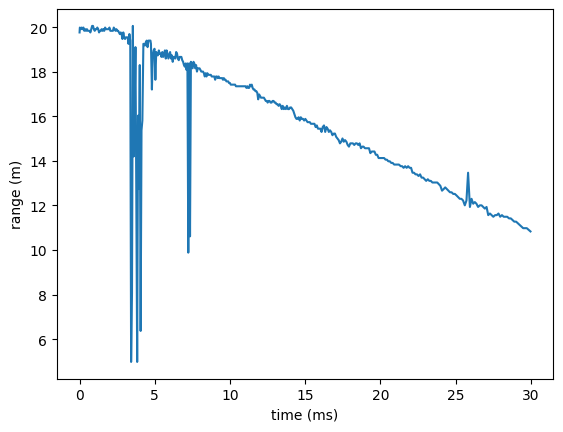

('start processing '
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141246-ryu_motion3-24GHz.pickle')


IntProgress(value=0, max=401)

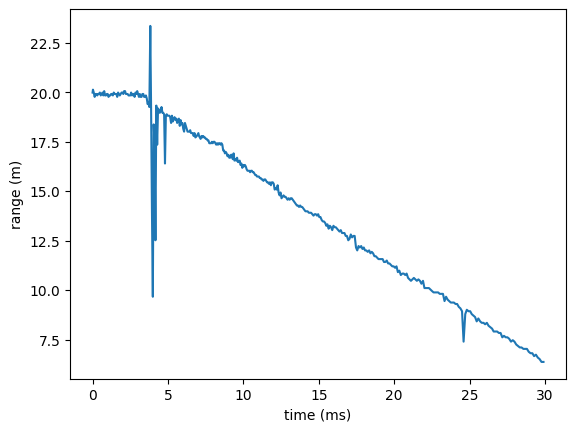

('start processing '
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141341-ryu_motion3-24GHz.pickle')


IntProgress(value=0, max=403)

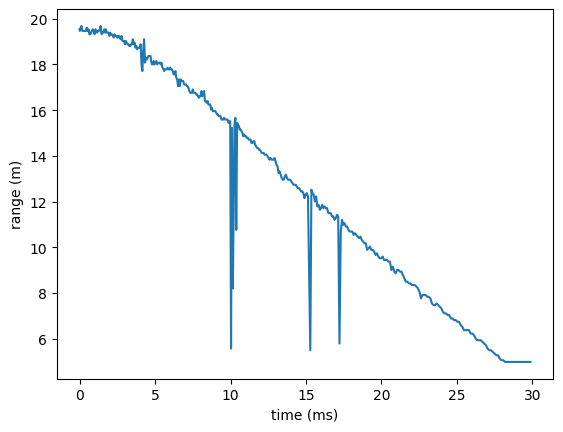

('start processing '
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141537-ryu_motion3-24GHz.pickle')


IntProgress(value=0, max=399)

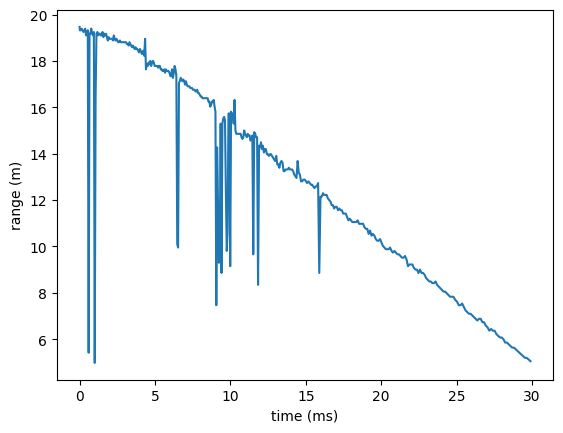

('start processing '
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141733-ryu_motion3-24GHz.pickle')


IntProgress(value=0, max=381)

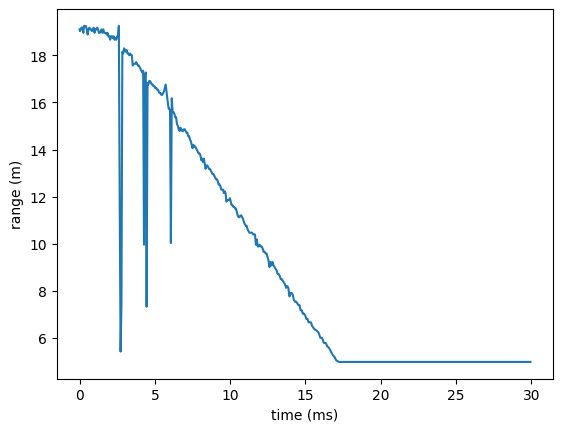

('start processing '
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141830-ryu_motion3-24GHz.pickle')


IntProgress(value=0, max=402)

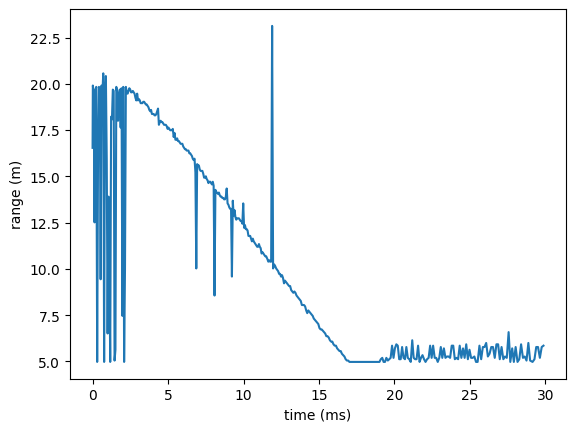

('start processing '
 '/Users/Anant/MMetroDEnv/PythonCodev2/Data/230213-141931-ryu_motion3-24GHz.pickle')


IntProgress(value=0, max=403)

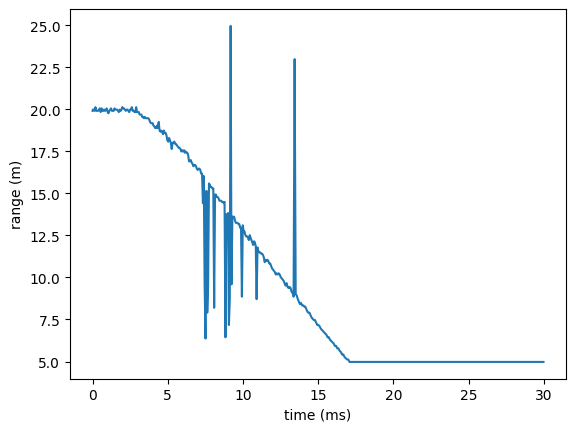

In [60]:
process_plot(names)